# Plasma Scattering Matrix Measurement
This notebook aims to illustrate the methodology to measure the plasma/antenna S-matrix of a WEST plasma.

In [1]:
%load_ext autoreload
%autoreload 2

# Numerical Reference
Before going into the mathematical details and numerical implementation, let's first create a numerical reference antenna. This reference model will serve us to simulate the behaviour of a real antenna when excited by different  power and phase. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import skrf as rf
rf.stylely()  # pretty plots
from tqdm.notebook import tqdm
# WEST ICRH Antenna package
import sys; sys.path.append('..')
from west_ic_antenna import WestIcrhAntenna

In [3]:
# S-matrix from HFSS non-homogeneous realistic Cold Plasma
Smat_ref = rf.Network('Full_torus_ICLH_plasma_6s_HFSSDesign1.s4p')
Smat_ref

4-Port Network: 'Full_torus_ICLH_plasma_6s_HFSSDesign1',  0.055-0.055 GHz, 1 pts, z0=[46.6303376 +0.j 46.63063457+0.j 46.62013232+0.j 46.6304588 +0.j]

In [4]:
ant_ref = WestIcrhAntenna(frequency=Smat_ref.frequency, front_face=Smat_ref)

Let's find the best capacitor set to match the antenna: 

In [5]:
# perfect dipole excitation
powers = [1e6, 1e6]
phases = [0, np.pi]

In [6]:
C_match = ant_ref.match_both_sides(f_match=55e6, power=powers, phase=phases)

Looking for individual solutions separately for 1st guess...
True solution #1: [58.01034275 49.97464714]
Wrong solution (out of range capacitor) ! Re-doing...
False solution #1: [45.46044926 12.        ]
True solution #1: [57.90207118 49.90862901]
Searching for the active match point solution...
Reducing search range to +/- 5pF around individual solutions
True solution #1: [59.73644167 50.15877265 59.69761854 50.20002129]


To verify the matching, let's look at the SWR as seen from the back of the antenna:

In [7]:
ant_ref.vswr_act(powers, phases, Cs=C_match)

array([1.00234471, 1.00167276])

# Problem Description
One WEST ICRH antenna radiating on plasma can be model as the following Figure.

<center><img src="West_Antenna_Simplified_Electric_Model.png" align="center" width="600"/></center>

where:
- $\mathbf{S}^p$ is the plasma/front-face S-parameters
- $\mathbf{S}^{mL}$ and $\mathbf{S}^{mR}$ are the antenna side modules. Capacitors are embedded in these modules, so $\mathbf{S}^{mL}$ depends on $C_1$ and $C_2$ and $\mathbf{S}^{mR}$ depends on $C_3$ and $C_4$ capacitances. In the following, these two modules are supposed to be known (from the electric modelling of the antenna).
- $\mathbf{S}^{ant}$ represents both modules
- $\mathbf{S}^{mes}$ is the S-parameters directly accessible from the RF measurements realized behind the antenna (see after for details)

We have per definition for $\mathbf{S}^{mes}$:
$$
\left(
\begin{array}{c}
b^L \\
b^R
\end{array}
\right)
=
\mathbf{S}^{mes}
\left(
\begin{array}{c}
a^L \\
a^R
\end{array}
\right)
$$

and for $\mathbf{S}^{p}$
$$
\left(
\begin{array}{c}
b_1 \\
\vdots \\
b_4
\end{array}
\right)
=
\mathbf{b}^p
=
\mathbf{S}^p
\mathbf{a}^p
=
\mathbf{S}^p
\left(
\begin{array}{c}
a_1 \\
\vdots \\
a_4
\end{array}
\right)
$$

and for $\mathbf{S}^{ant}$,
$$
\left(
\begin{array}{c}
b_L \\
b_R \\
\mathbf{a}^p
\end{array}
\right)
=
\mathbf{S}^{ant}
\left(
\begin{array}{c}
a_L \\
a_R \\
\mathbf{b}^p
\end{array}
\right)
$$
as some output waves of the modules are the input waves of the plasma.

With the previous notation, it is convenient to decompose the antenna S-matrix $\mathbf{S}^{ant}$ into 4 submatrices $\mathbf{S}^{ant}_{11}, \mathbf{S}^{ant}_{12}, \mathbf{S}^{ant}_{21}, \mathbf{S}^{ant}_{22}$:
$$
\mathbf{S}^{ant}
=
\left(
\begin{array}{cc}
\mathbf{S}^{ant}_{11} & \mathbf{S}^{ant}_{12} \\
\mathbf{S}^{ant}_{21} & \mathbf{S}^{ant}_{22}
\end{array}
\right)
$$
where:
- $\mathbf{S}^{ant}_{11}$ is of shape (2,2)
- $\mathbf{S}^{ant}_{12}$ is of shape (2,4)
- $\mathbf{S}^{ant}_{21}$ is of shape (4,2) and
- $\mathbf{S}^{ant}_{22}$ is of shape (4,4)

This notation allows to expand the previous definition as:
$$
\left(
\begin{array}{c}
b^L \\
b^R
\end{array}
\right)
=
\mathbf{S}^{ant}_{11}
\left(
\begin{array}{c}
a^L \\
a^R
\end{array}
\right)
+
\mathbf{S}^{ant}_{12}
\mathbf{b}^p
$$
and
$$
\mathbf{a}^p
=
\mathbf{S}^{ant}_{21}
\left(
\begin{array}{c}
a^L \\
a^R
\end{array}
\right)
+
\mathbf{S}^{ant}_{22}
\mathbf{b}^p
$$

Inserting the definition of $S$^p leads to:
$$
\left(
\begin{array}{c}
b^L \\
b^R
\end{array}
\right)
=
\left[
\mathbf{S}^{ant}_{11}
+
\mathbf{S}^{ant}_{12} \mathbf{S}^p 
\left(\mathbf{1} - \mathbf{S}^{ant}_{22} \mathbf{S}^p \right)^{-1} 
\mathbf{S}^{ant}_{21}
\right]
\left(
\begin{array}{c}
a^L \\
a^R
\end{array}
\right)
$$

which matches the definition of $S^{mes}$, hence by identification:
$$
\boxed{
\mathbf{S}^{mes}
=
\mathbf{S}^{ant}_{11}
+
\mathbf{S}^{ant}_{12} \mathbf{S}^p 
\left(\mathbf{1} - \mathbf{S}^{ant}_{22} \mathbf{S}^p \right)^{-1} 
\mathbf{S}^{ant}_{21}
}
$$

$\mathbf{S}^{mes}$ can be measured using (at least) two different set of antenna excitation, ie. forward waves $(a^L, a^R)$ and associated reflected waves $(b^L, b^R)$: 
$$
\left(
\begin{array}{cc}
b_L^{(1)} & b_L^{(2)}  \\
b_R^{(1)} & b_R^{(2)}  \\
\end{array}
\right)
=
\mathbf{S}^{mes}
\left(
\begin{array}{cc}
a_L^{(1)} & a_L^{(2)}  \\
a_R^{(1)} & a_R^{(2)}  \\
\end{array}
\right)
$$

which leads to:
$$
\mathbf{S}^{mes} 
= 
\left(
\begin{array}{cc}
b_L^{(1)} & b_L^{(2)}  \\
b_R^{(1)} & b_R^{(2)}  \\
\end{array}
\right)
\left(
\begin{array}{cc}
a_L^{(1)} & a_L^{(2)}  \\
a_R^{(1)} & a_R^{(2)}  \\
\end{array}
\right)^{-1}
$$

From the knowledge of $\mathbf{S}^{mes}$, one can deduce $\mathbf{S}^p$:
$$
\boxed{
\mathbf{S}^p
=
\left(
\mathbf{1} + \mathbf{M} \mathbf{S}_{22}^{ant}
\right)^{-1}
\mathbf{M}
}
$$

with:
$$
\mathbf{M}
=
\left(
S_{12}^{ant}
\right)^{-1}
\left(
\mathbf{S}^{mes} - S_{11}^{ant}
\right)
\left(
S_{21}^{ant}
\right)^{-1}
$$
where the inverse of $S_{12}^{ant}$ and $S_{12}^{ant}$ are pseudo-inverse matrices.

# Numerical Test

## Antenna Excitations

Numerical measured quantities behind the antenna $a^{mes}$ and $b^{mes}$ for a set of excitation (power and phase)

In [8]:
# phase scan (constant power)
dphis = np.pi + np.deg2rad(np.array([-30, 20])) # dipole + some phase shift
powers = np.array([[1, 1], [1, 1]]) 
_as = []
_bs = []

for power, dphi in zip(powers, dphis):
    _phase = [0, np.pi + dphi]
    _a = ant_ref.circuit(Cs=C_match)._a_external(power, _phase)
    _as.append(_a)
    _bs.append(ant_ref.circuit(Cs=C_match).s_external @ _a)

a_mes = np.array(_as)
b_mes = np.array(_bs).squeeze()

# adding some noise
noise_level = 1e-3
noise_a = noise_level*(np.random.rand(2,2) + 1j*np.random.rand(2,2))
noise_b = noise_level*(np.random.rand(2,2) + 1j*np.random.rand(2,2))
a_mes += noise_a
b_mes += noise_b

print(a_mes.shape, b_mes.shape)

(2, 2) (2, 2)


In [9]:
b_mes

array([[-0.2457543 +0.72203664j, -0.25824202+0.67989016j],
       [-0.53823572+0.5616933j , -0.53116567+0.51638929j]])

## Antenna S-matrix

Since we have for $M=2$ measurements 
$$
\mathbf{B}^{mes}
=
\left(
\begin{array}{cc}
b_L^{(1)} & b_L^{(2)}  \\
b_R^{(1)} & b_R^{(2)}  \\
\end{array}
\right)
=
\mathbf{S}^{mes}
\left(
\begin{array}{cc}
a_L^{(1)} & a_L^{(2)}  \\
a_R^{(1)} & a_R^{(2)}  \\
\end{array}
\right)
=
\mathbf{S}^{mes}
\mathbf{A}^{mes}
$$

In [10]:
A_mes = a_mes.T

In [11]:
B_mes = b_mes.T

So, 
$$
\mathbf{S}^{mes} = \mathbf{B}^{mes} \left( \mathbf{A}^{mes} \right)^{-1}
$$

In [12]:
S_mes = B_mes @ np.linalg.inv(A_mes)
S_mes.shape

(2, 2)

In [13]:

V_exp = np.abs(S_mes.squeeze())
V_the = np.abs(ant_ref.circuit(Cs=C_match).network.s.squeeze())

print(V_exp)
print(V_the)

[[0.27908672 0.2792119 ]
 [0.26561191 0.26632157]]
[[0.27915214 0.27927439]
 [0.26592514 0.26593378]]


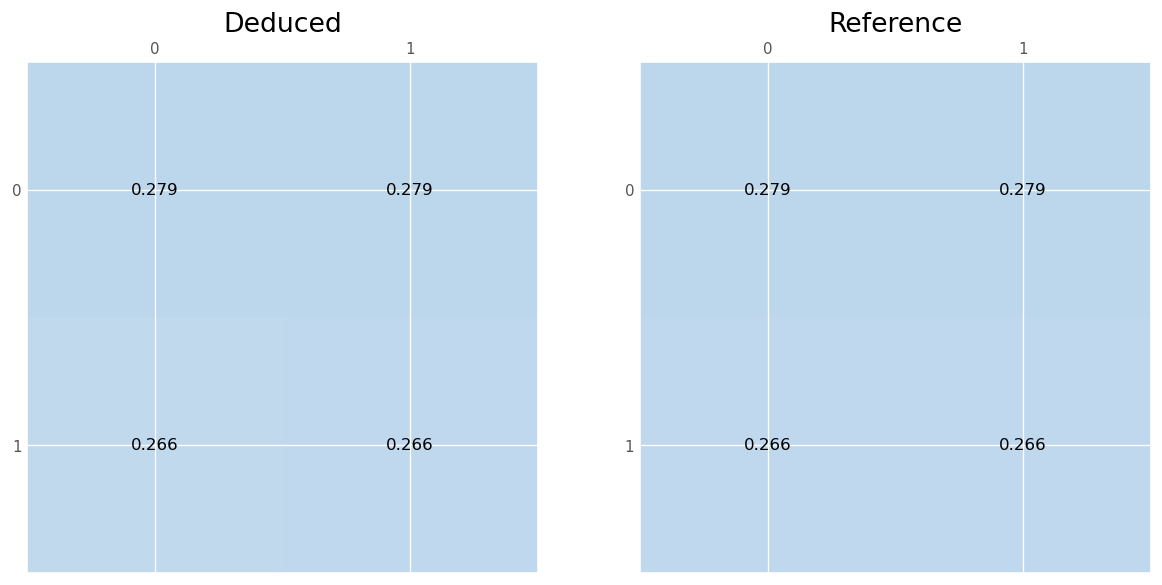

In [22]:
fig, axes = plt.subplots(1,2, figsize=(12,10))

axes[0].matshow(V_exp, cmap=plt.cm.Blues, vmin=0, vmax=1)
axes[0].set_title('Deduced')
axes[1].matshow(V_the, cmap=plt.cm.Blues, vmin=0, vmax=1)
axes[1].set_title('Reference')
for i in range(2):
    for j in range(2):
        axes[1].text(i, j, f'{V_the[j,i]:.3}', va='center', ha='center')
        axes[0].text(i, j, f'{V_exp[j,i]:.3}', va='center', ha='center')

In [15]:
V_exp2 = np.angle(S_mes.squeeze(), deg=True)
V_the2 = np.angle(ant_ref.circuit(Cs=C_match).network.s.squeeze(), deg=True)

print(V_exp2)
print(V_the2)

[[123.76150267 123.78238164]
 [125.60612043 125.97455712]]
[[123.98632773 123.7473502 ]
 [125.74244947 125.92249162]]


It works for the antenna S-matrix !

## Plasma/Front-Face Scattering Parameters

In [16]:
access = ant_ref._access_circuit(Cs=C_match).network
S_ant = access.s
print(S_ant.shape)

(1, 6, 6)


In [17]:
S_ant11 = S_ant[:,:2,:2].squeeze()
S_ant12 = S_ant[:,:2,2:].squeeze()
S_ant21 = S_ant[:,2:,:2].squeeze()
S_ant22 = S_ant[:,2:,2:].squeeze()

The plasma matrix is:
$$
\mathbf{S}^p
=
\left(
\mathbf{1} + \mathbf{M} \mathbf{S}_{11}^{ant}
\right)^{-1}
\mathbf{M}
$$

In [18]:
M = np.linalg.pinv(S_ant12) @ (S_mes - S_ant11) @ np.linalg.pinv(S_ant21)
M.shape

(4, 4)

In [19]:
S_p = np.linalg.inv(np.eye(len(M)) + M @ S_ant22) @ M
S_p.shape

(4, 4)

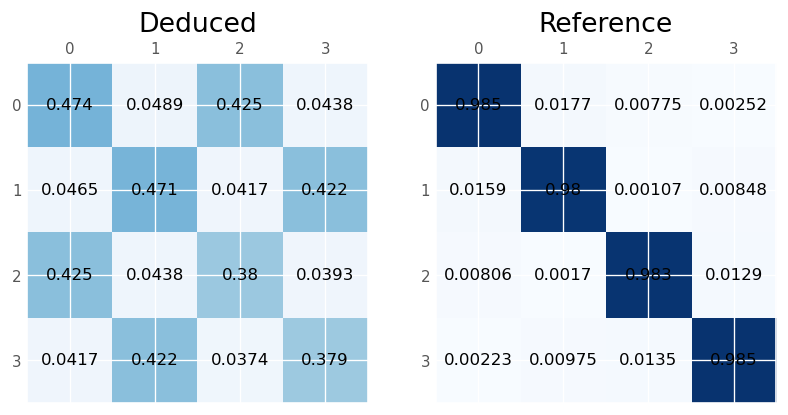

In [23]:
fig, axes = plt.subplots(1,2, figsize=(8,6))
v_exp = np.abs(S_p.squeeze())
v_ref = np.abs(Smat_ref.s.squeeze())

axes[0].matshow(v_exp, cmap=plt.cm.Blues, vmin=0, vmax=1)
axes[0].set_title('Deduced')
axes[1].matshow(v_ref, cmap=plt.cm.Blues, vmin=0, vmax=1)       
axes[1].set_title('Reference')
for i in range(4):
    for j in range(4):
        axes[0].text(i, j, f'{v_exp[j,i]:.3}', va='center', ha='center')
        axes[1].text(i, j, f'{v_ref[j,i]:.3}', va='center', ha='center')

It doesn't work!

# CSS

In [21]:
from IPython.core.display import HTML
def _set_css_style(css_file_path):
    """
    Read the custom CSS file and load it into Jupyter
    Pass the file path to the CSS file
    """
    styles = open(css_file_path, "r").read()
    s = '<style>%s</style>' % styles
    return HTML(s)

_set_css_style('custom.css')